In [1]:
%load_ext autoreload
%autoreload 1
%aimport pycabnn

/Users/shhong/Documents/Josefine/pycabnn/notebooks/pycabnn/connector.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pycabnn as cbn

from scipy.spatial import KDTree
from scipy.spatial.distance import pdist
from scipy.optimize import curve_fit

import dask.dataframe as dd
from tqdm.dask import TqdmCallback
from dask.diagnostics import ProgressBar

from tqdm.autonotebook import tqdm, trange

In [3]:
from pycabnn.util import HocParameterParser

h = HocParameterParser()
config_hoc = str("../test_data/params/Parameters.hoc")
h.load_file(config_hoc)


In [4]:
mlipop = cbn.create_population("MLI", h)
mlipop.load_somata("../../big_test_data/MLIcoordinates.dat")
mlipop.add_dendrites()

Successfully read ../../big_test_data/MLIcoordinates.dat.


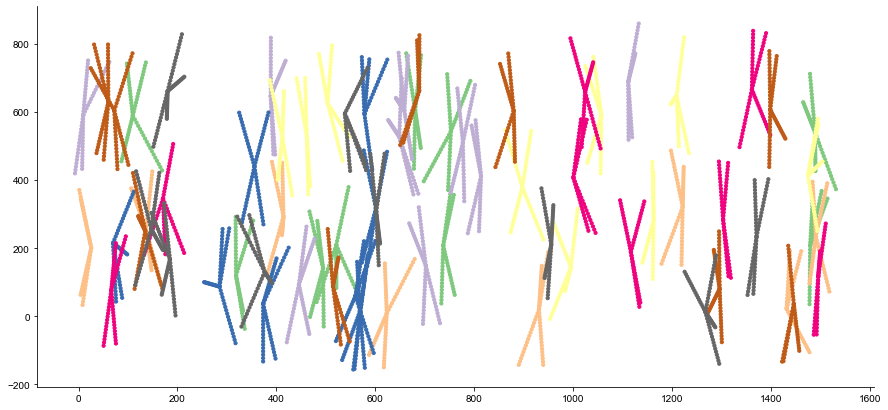

In [5]:
ncell = 70
nidx = ncell*90*4

_, ax = plt.subplots(figsize=(15,7))
ax.scatter(
    mlipop.dends.coo[:nidx:5,0],
    mlipop.dends.coo[:nidx:5,1], 
    10, 
    mlipop.dends.idx[:nidx:5], 
    cmap='Accent'
)

In [6]:
dend_coo = np.reshape(mlipop.dends.coo, (-1, 4, 90, 3))
som = mlipop.som

In [7]:
def compute_soma_dist(som):
    temp1 = pdist(som[:,[1, 2]])
    temp2 = pdist(som[:, 0][:, np.newaxis])
    som_dist = pd.DataFrame(np.zeros((temp1.shape[0], 2), dtype=int), columns=['i', 'j'])
    ifirst = 0
    ilast = som.shape[0]-1
    for i in trange(som.shape[0]-1):
        som_dist.iloc[ifirst:ilast, 0] = i
        som_dist.iloc[ifirst:ilast, 1] = np.arange(i+1, som.shape[0], dtype=int)
        ifirst = ilast
        ilast = ifirst + som.shape[0]-(i+2)
        
    som_dist['dist_xy'] = temp1
    som_dist['dist_z'] = temp2
    return som_dist

som_dist = compute_soma_dist(mlipop.som)

som_dist = som_dist[som_dist['dist_xy'] < 180]
som_dist = som_dist[som_dist['dist_z'] < 50]

  0%|          | 0/19723 [00:00<?, ?it/s]

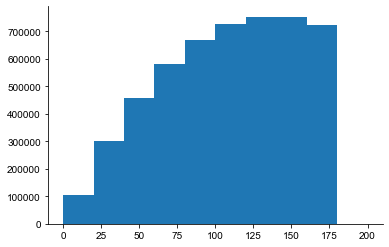

In [8]:
_ = plt.hist(som_dist['dist_xy'], bins=np.arange(0, 220, 20))

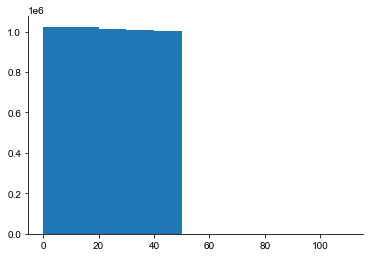

In [9]:
_ = plt.hist(som_dist['dist_z'], bins=np.arange(0, 120, 10))

## Distance vs connectivity data

In [10]:
p_dist_xy = np.loadtxt('p_dist_xy.csv', delimiter=',')
p_dist_z = np.loadtxt('p_dist_z.csv', delimiter=',')

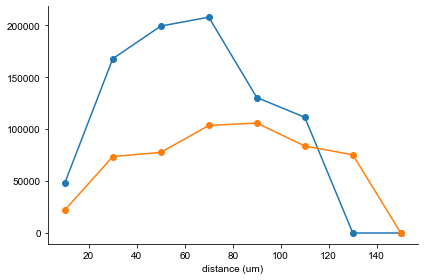

In [12]:
nxy, c = np.histogram(som_dist['dist_xy'], bins=np.arange(0, 180, 20))

def plot_dist(x, y, fname):
    plt.plot(x, y, '-o')
    plt.xlabel("distance (um)")
    plt.tight_layout()
    plt.savefig(fname)
    
plot_dist(p_dist_xy[:,0], nxy[:,np.newaxis]*p_dist_xy[:,1:], 'MLI_fit_conn_func/pdata_xy.png')

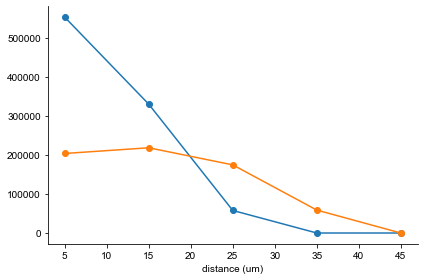

In [13]:
nz, c = np.histogram(som_dist['dist_z'], bins=np.arange(0, 60, 10))
plot_dist(p_dist_z[:,0], nz[:,np.newaxis]*p_dist_z[:,1:], 'MLI_fit_conn_func/pdata_z.png')

### Fit: XY

In [14]:
def f_fit(x, mu, a, N):
    return N*np.exp(-a*(x-mu)*(x-mu))*x

p_xy = curve_fit(f_fit, p_dist_xy[:,0], nxy*p_dist_xy[:,1], p0=[50, 0.001, 100000])
print(p_xy[0])

[2.08043970e+01 2.55078353e-04 5.31416508e+03]


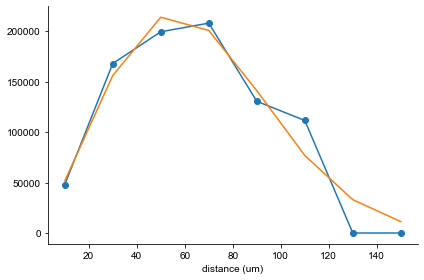

In [15]:
def plot_dist2(x, y, y2, fname=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.plot(x, y, "o-", x, y2)
    ax.set_xlabel("distance (um)")
    if fname:
        plt.tight_layout()
        plt.savefig(fname)


plot_dist2(
    p_dist_xy[:, 0],
    p_dist_xy[:, 1] * nxy,
    f_fit(p_dist_xy[:, 0], *p_xy[0]),
    "MLI_fit_conn_func/pdist_gap_xy_fit.png",
)


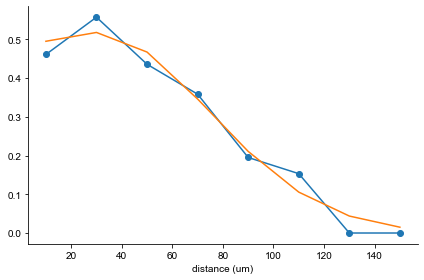

In [16]:
plot_dist2(
    p_dist_xy[:, 0],
    p_dist_xy[:, 1],
    f_fit(p_dist_xy[:, 0], *p_xy[0]) / nxy,
    "MLI_fit_conn_func/ppost_gap_xy_fit.png",
)

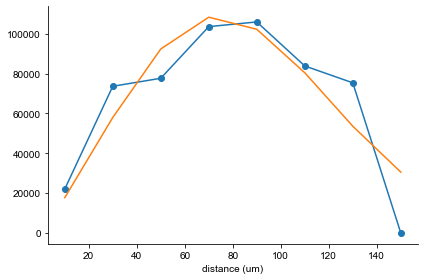

In [17]:
p_xy = curve_fit(f_fit, p_dist_xy[:,0], nxy*p_dist_xy[:,2], p0=[50, 0.001, 100000])

plot_dist2(
    p_dist_xy[:, 0],
    nxy * p_dist_xy[:, 2],
    f_fit(p_dist_xy[:, 0], *p_xy[0]),
    "MLI_fit_conn_func/pdata_syn_xy_fit.png",
)

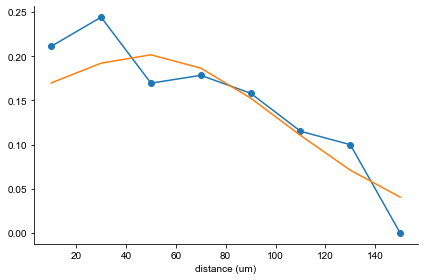

In [18]:
plot_dist2(
    p_dist_xy[:, 0],
    p_dist_xy[:, 2],
    f_fit(p_dist_xy[:, 0], *p_xy[0]) / nxy,
    "MLI_fit_conn_func/ppost_syn_xy_fit.png"
)

### Fit XY with prior fit

In [19]:
nxy, _ = np.histogram(som_dist['dist_xy'], bins=np.arange(0, 180, 20))

In [20]:
def f_fit(x, mu, a, N):
    return N*np.exp(-a*(x-mu)*(x-mu))*x

p_pxy = curve_fit(f_fit, p_dist_xy[:,0], nxy, p0=[50, 0.001, 100000])
p_xy = curve_fit(f_fit, p_dist_xy[:,0], nxy*p_dist_xy[:,1], p0=[50, 0.001, 100000])
print(p_pxy[0])

[-1.09634625e+02  1.43100368e-05  1.31777106e+04]


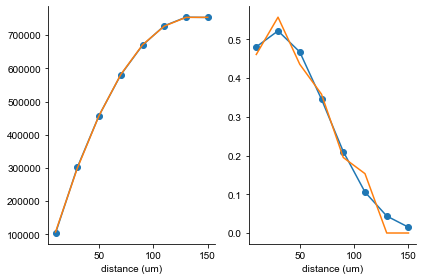

In [21]:
_, (ax1, ax2) = plt.subplots(ncols=2)

plot_dist2(p_dist_xy[:, 0], nxy, f_fit(p_dist_xy[:, 0], *p_pxy[0]), ax=ax1)
plot_dist2(
    p_dist_xy[:, 0],
    f_fit(p_dist_xy[:, 0], *p_xy[0]) / f_fit(p_dist_xy[:, 0], *p_pxy[0]),
    p_dist_xy[:, 1],
    ax=ax2,
)
plt.tight_layout()
plt.savefig("MLI_fit_conn_func/ppost_gap_xy+prior_fit.png")

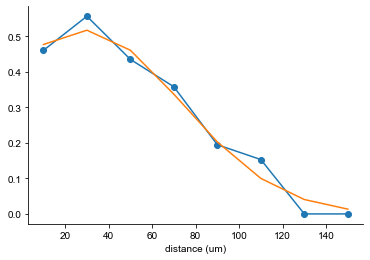

In [22]:
plot_dist2(
    p_dist_xy[:, 0],
    p_dist_xy[:, 1],
    f_fit(p_dist_xy[:, 0], 20.8, 2.6e-4, 5300)
    / f_fit(p_dist_xy[:, 0], -110, 1.4e-5, 13177),
)
plt.savefig("MLI_fit_conn_func/ppost_gap_xy_final.png")

In [23]:
p_xy = curve_fit(f_fit, p_dist_xy[:,0], nxy*p_dist_xy[:,2], p0=[50, 0.001, 100000])
print(p_xy[0])

[3.31682905e+01 1.64911617e-04 1.93526142e+03]


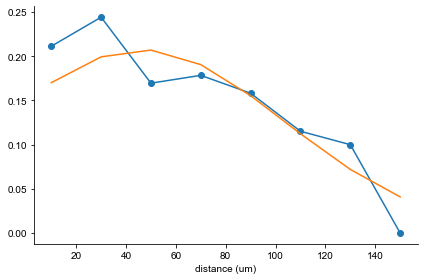

In [24]:
plot_dist2(
    p_dist_xy[:, 0],
    p_dist_xy[:, 2],
    f_fit(p_dist_xy[:, 0], 33, 1.65e-4, 2000)
    / f_fit(p_dist_xy[:, 0], -110, 1.4e-5, 13177),
    "MLI_fit_conn_func/ppost_syn_xy_final.png",
)


### Fit: Z

In [25]:
def f_fit(x, mu, a, N):
    return N * np.exp(-a * (x - mu) * (x - mu))


p_pz = curve_fit(f_fit, p_dist_z[:, 0], nz, p0=[50, 0.001, 100000])
p_z = curve_fit(f_fit, p_dist_z[:,0], nz*p_dist_z[:,1], p0=[10, 0.001, 100000])
# p_pz


/var/folders/dd/lzv3mtbd2555qjgqz9j9nbtc0000gn/T/ipykernel_55791/2599483805.py:2: RuntimeWarning: overflow encountered in exp
  return N * np.exp(-a * (x - mu) * (x - mu))


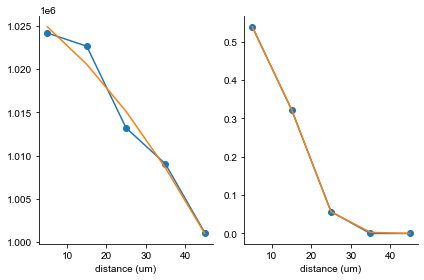

In [26]:
_, (ax1, ax2) = plt.subplots(ncols=2)

plot_dist2(p_dist_z[:, 0], nz, f_fit(p_dist_z[:, 0], *p_pz[0]), ax=ax1)
plot_dist2(
    p_dist_z[:, 0],
    p_dist_z[:, 1],
    f_fit(p_dist_z[:, 0], *p_z[0]) / f_fit(p_dist_z[:, 0], *p_pz[0]),
    ax=ax2,
)
plt.tight_layout()
plt.savefig("MLI_fit_conn_func/ppost_gap_z+prior_fit.png")

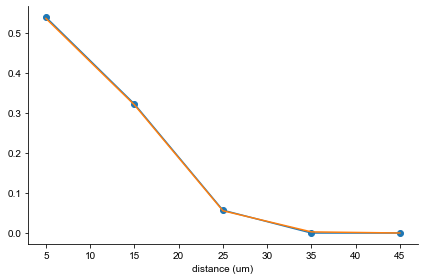

In [27]:
plot_dist2(
    p_dist_z[:, 0],
    p_dist_z[:, 1],
    f_fit(p_dist_z[:, 0], *p_z[0]) / f_fit(p_dist_z[:, 0], 0, 0, 1.03e6),
    "MLI_fit_conn_func/ppost_gap_z_final.png",
)


In [30]:
p_z = curve_fit(f_fit, p_dist_z[:,0], nz*p_dist_z[:,2], p0=[10, 0.001, 100000])
print(p_z[0])

[1.28960198e+01 2.64170525e-03 2.33702630e+05]


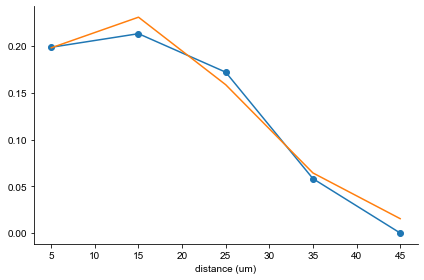

In [31]:
plot_dist2(
    p_dist_z[:, 0],
    p_dist_z[:, 2],
    f_fit(p_dist_z[:, 0], *p_z[0]) / f_fit(p_dist_z[:, 0], 0, 0, 1e6),
    "MLI_fit_conn_func/ppost_syn_z_final.png",
)
